In [1]:
# New York Taxi-Fare Prediction
# Shantanu Deore C1-43
# Abhijeet Boje C1-49

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x) 
RSEED = 100
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
palette = sns.color_palette('Paired', 10)

In [2]:
data = pd.read_csv('../input/train.csv', nrows = 50000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
1,2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2,2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
3,2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
4,2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,11.364,-72.510,39.934,-72.505,39.926,1.668
std,9.686,10.394,6.225,10.408,6.015,1.289
min,-5.000,-75.424,-74.007,-84.654,-74.006,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,200.000,40.783,401.083,40.851,43.415,6.000


In [4]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data = data.drop(columns = 'key')
# Remove null attributes
data = data.dropna()

In [5]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 6 negative fares.
There are 3 $0 fares.
There are 16 fares greater than $100.


In [6]:
data = data[data['fare_amount'].between(left = 2.5, right = 100)]

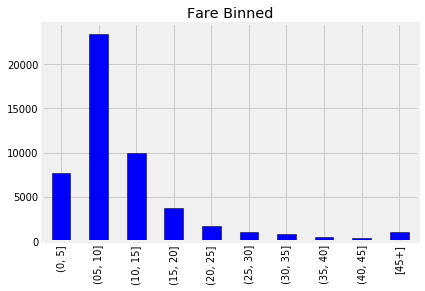

In [7]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

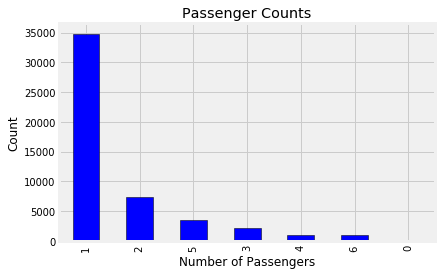

In [8]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

In [ ]:
data = data.loc[data['passenger_count'] < 6]

In [ ]:
print(f'Initial Observations: {data.shape[0]}')
# Remove latitude and longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

print(f'New number of observations: {data.shape[0]}')

In [ ]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

In [ ]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

In [ ]:
#TEST

test = pd.read_csv('../input/test.csv', parse_dates = ['pickup_datetime'])

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

In [ ]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [ ]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

In [ ]:
subset = data.sample(10000, random_state=RSEED)

In [ ]:
data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

In [ ]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 10000)

In [ ]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)}')

In [ ]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

In [ ]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)}')

In [ ]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.head(10)

In [ ]:
lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

In [ ]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

In [ ]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [ ]:
# Evaluate using 8 features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [ ]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [ ]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

In [ ]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 10000)

In [ ]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [ ]:
# Test using the features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

In [ ]:
lr = LinearRegression()

# Fit and evaluate
lr.fit(X_train[features], y_train)
evaluate(lr, features, X_train, X_valid, y_train, y_valid)

Excluding Time Features

Regression RdmFrst  
5.14       2.28
6.08       4.7

Including Time Features 

Regression   RdmFrst
4.93         1.57
5.79         3.93